In [1]:
# Cell 1: Import Required Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Cell 2: Extract Core Lengths and Load Segment Pool
from pyCoreRelator import load_segment_pool

# Define core names and target parameters
CORE_A = "M9907-23PC"
CORE_B = "M9907-25PC"
LOG_COLUMNS = ['hiresMS']  # Choose one log column for segment pool
DEPTH_COLUMN = 'SB_DEPTH_cm'

# Define directory paths
mother_dir = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites'

# Function to extract core length from depth data
def get_core_length(core_name, depth_column='SB_DEPTH_cm'):
    """Extract maximum depth from core data"""
    # Try hiresMS file first (most common)
    depth_file = f'{mother_dir}/Cascadia_core_data/OSU_dataset/_compiled_logs/{core_name}/ML_filled/{core_name}_hiresMS_MLfilled.csv'
    try:
        df = pd.read_csv(depth_file)
        return df[depth_column].max()
    except:
        print(f"Warning: Could not read depth from {depth_file}")
        return None

# Extract core lengths
core_a_length = get_core_length(CORE_A, DEPTH_COLUMN)
core_b_length = get_core_length(CORE_B, DEPTH_COLUMN)

print(f"Core A ({CORE_A}) length: {core_a_length} cm")
print(f"Core B ({CORE_B}) length: {core_b_length} cm")

# Define all cores for segment pool
SEGMENT_POOL_CORES = ["M9907-22PC", "M9907-23PC", "M9907-25PC"]

# Define paths and parameters
CORE_LOG_PATHS = {
    core_name: {
        'hiresMS': f'{mother_dir}/Cascadia_core_data/OSU_dataset/_compiled_logs/{core_name}/ML_filled/{core_name}_hiresMS_MLfilled.csv'
    }
    for core_name in SEGMENT_POOL_CORES
}

COLUMN_ALTERNATIVES = {
    'hiresMS': ['MS'],
}

PICKED_DEPTH_PATHS = {
    core_name: f'{mother_dir}/pyCoreRelator/pickeddepth/{core_name}_pickeddepth.csv'
    for core_name in SEGMENT_POOL_CORES
}

# Execute the function using the imported function from pyCoreRelator
segment_pool_cores_data, turb_logs, depth_logs, target_dimensions = load_segment_pool(
    core_names=SEGMENT_POOL_CORES,
    core_log_paths=CORE_LOG_PATHS,
    picked_depth_paths=PICKED_DEPTH_PATHS,
    log_columns=LOG_COLUMNS,
    depth_column=DEPTH_COLUMN,
    column_alternatives=COLUMN_ALTERNATIVES,
    boundary_category=1
)

print(f"Core A target length: {core_a_length} cm")
print(f"Core B target length: {core_b_length} cm")

Core A (M9907-23PC) length: 783.0 cm
Core B (M9907-25PC) length: 797.0 cm
Loading segment pool from available cores...
Processing M9907-22PC...
  Loaded: 985 points, columns: ['hiresMS']
Processing M9907-23PC...
  Loaded: 1553 points, columns: ['hiresMS']
Processing M9907-25PC...
  Loaded: 1581 points, columns: ['hiresMS']
Segment pool created with 46 turbidites
Total cores processed: 3
Target dimensions: 1
Core A target length: 783.0 cm
Core B target length: 797.0 cm


Plotting 46 segments from the pool...


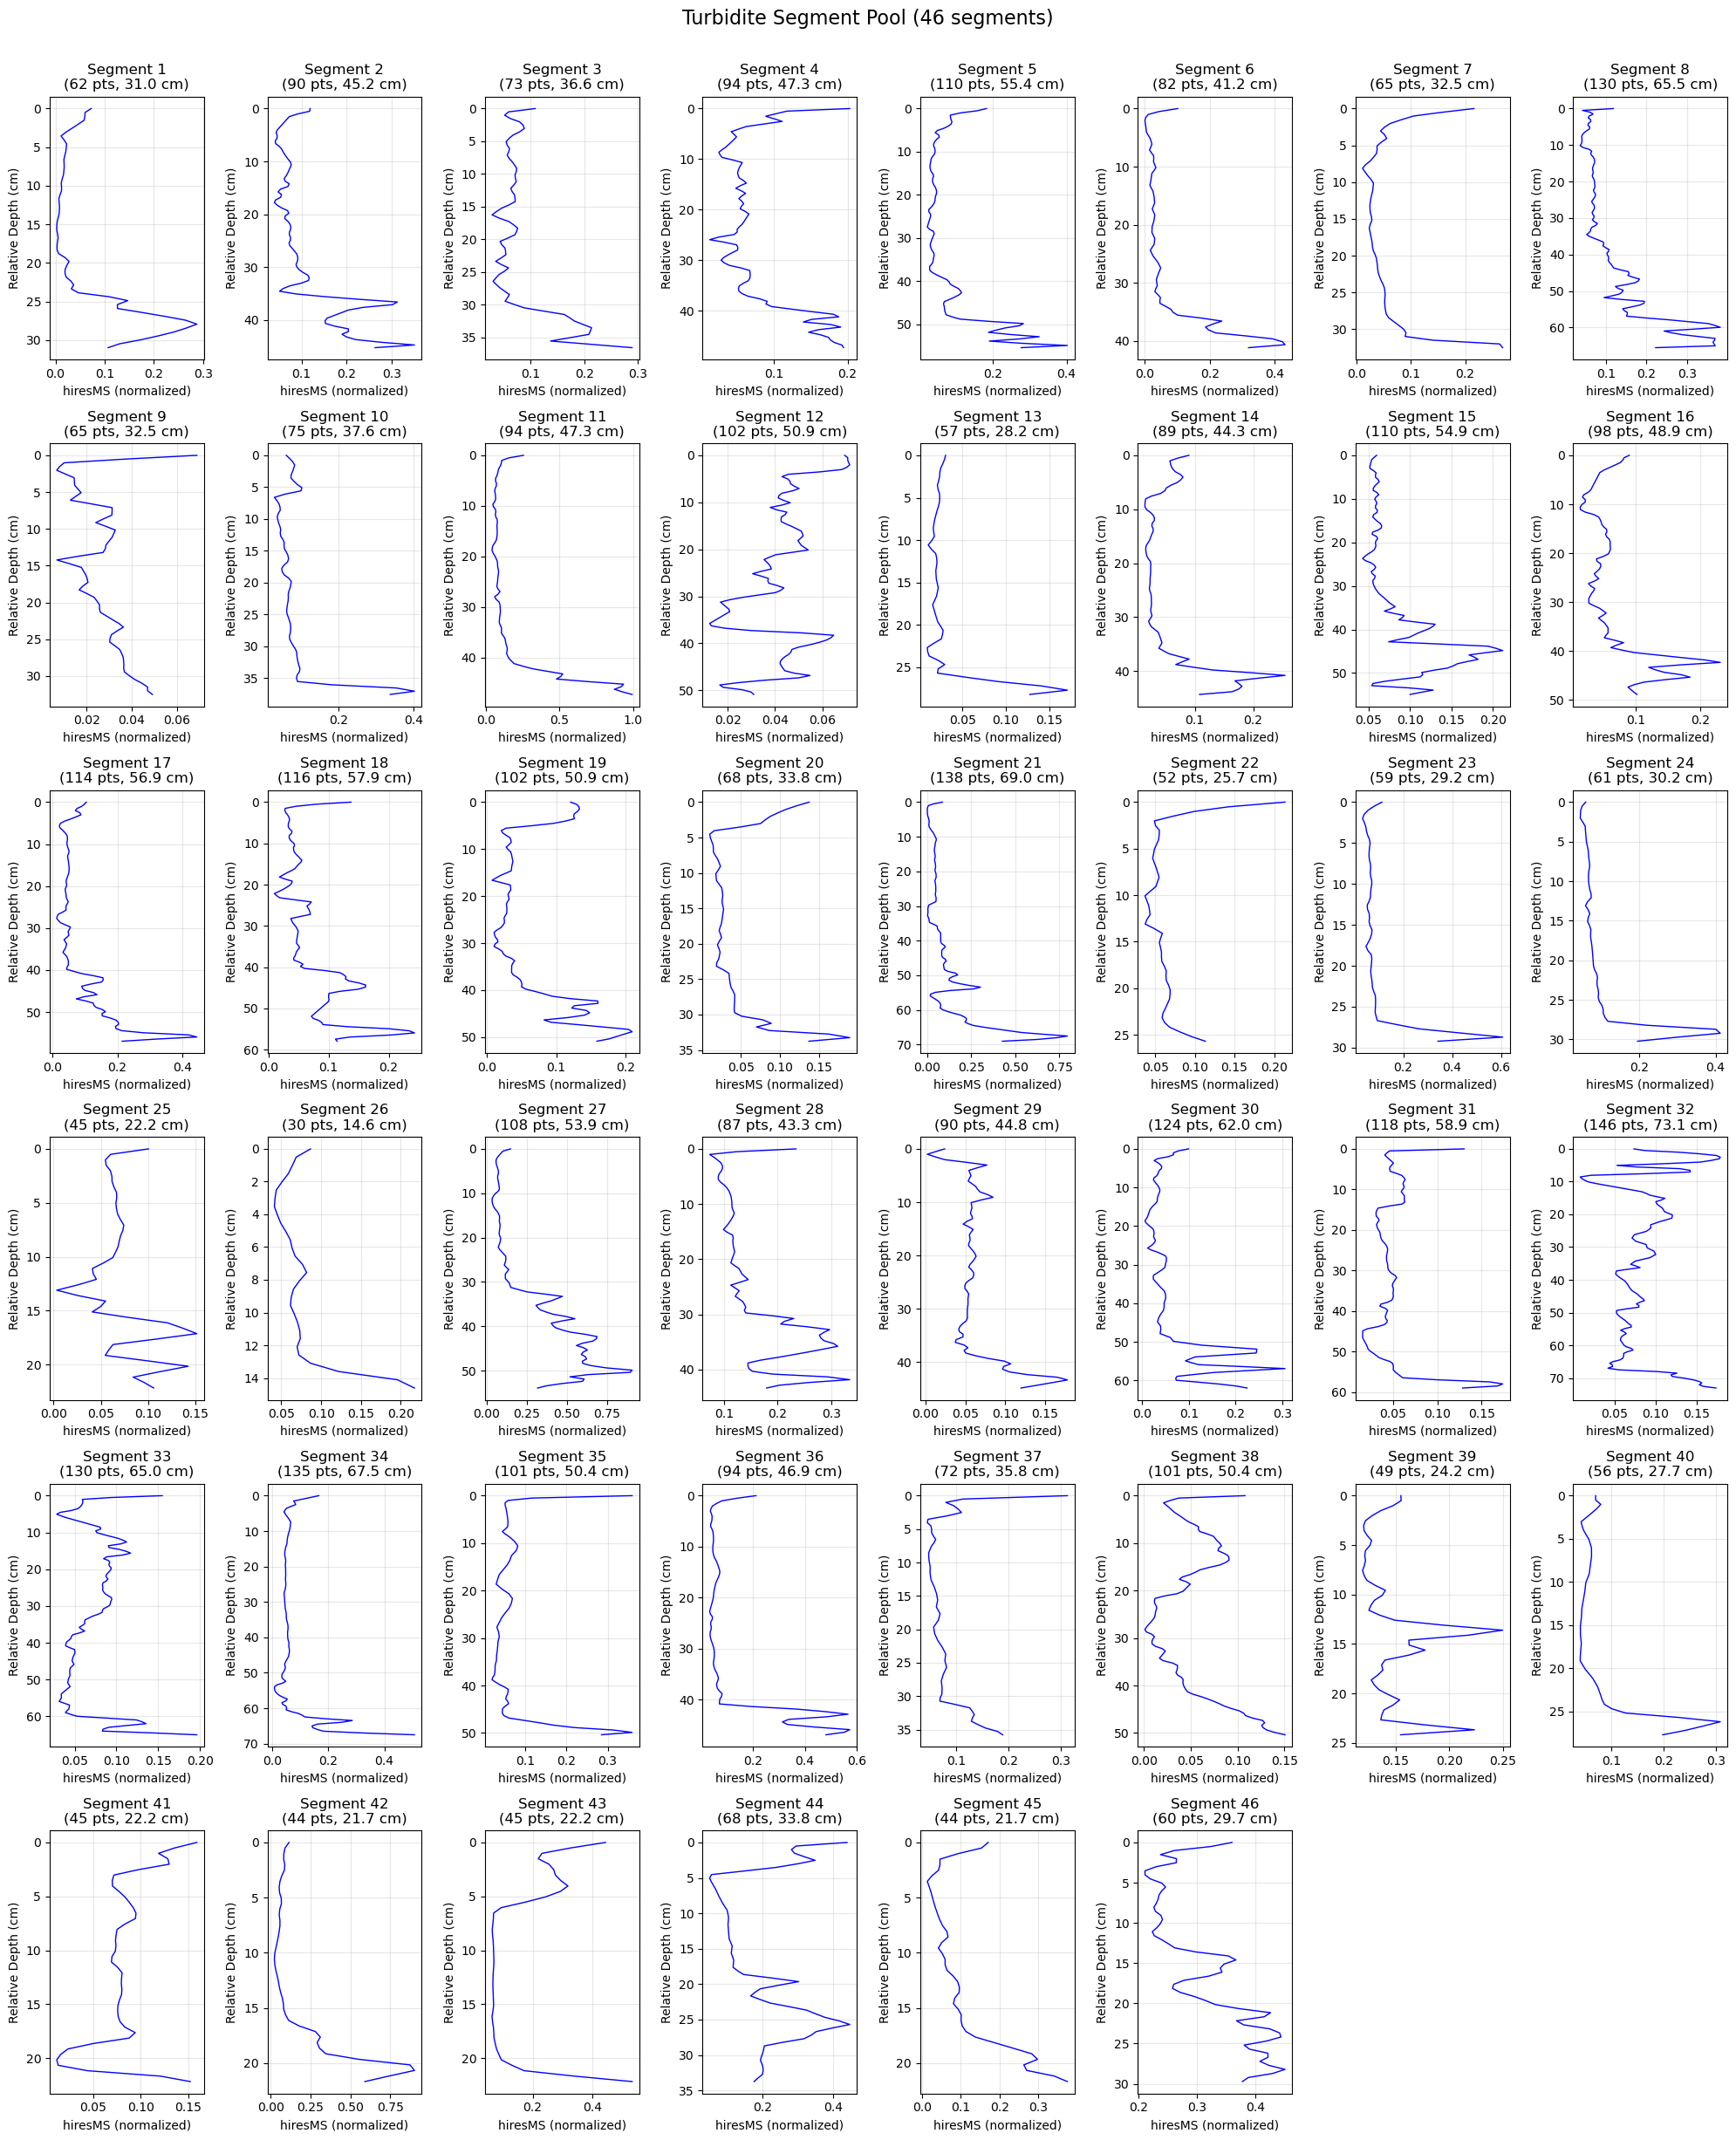


Segment Pool Summary:
  Total segments: 46
  Length range: 30-146 points
  Depth range: 14.6-73.1 cm
  Mean depth: 42.3 cm
  Target dimensions: 1


In [4]:
# Cell 3: Plot All Turbidite Segments from Pool
from pyCoreRelator import plot_segment_pool, print_segment_pool_summary

# Plot the segment pool using imported function
fig, axes = plot_segment_pool(
    segment_logs=turb_logs,
    segment_depths=depth_logs,
    log_column_names=LOG_COLUMNS,
    n_cols=8,
    figsize_per_row=4,
    plot_segments=True,
    save_plot=False,
    plot_filename=None
)

# Print summary statistics using imported function
print_segment_pool_summary(turb_logs, depth_logs, target_dimensions)

Generating synthetic core pair...


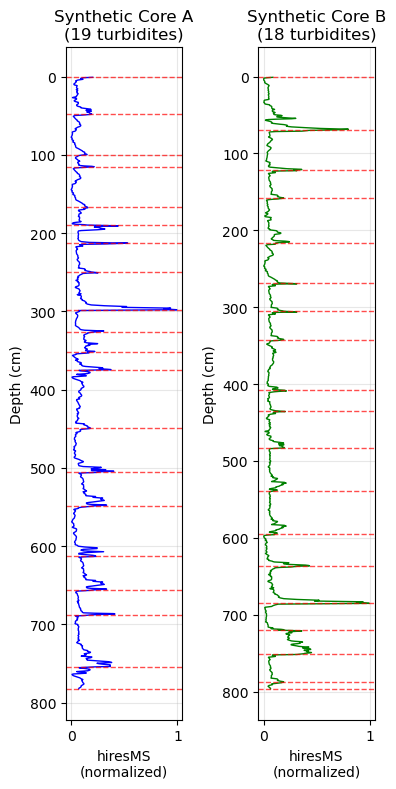

Synthetic Core A: 1531 points, 19 turbidites, 20 boundaries
Synthetic Core B: 1561 points, 18 turbidites, 19 boundaries
Turbidite indices used in A: [3, 37, 25, 37, 40, 42, 36, 10, 39, 38]...
Turbidite indices used in B: [20, 34, 36, 17, 37, 36, 36, 32, 21, 3]...


In [5]:
# Cell 4: Create and Plot Synthetic Core Pair
from pyCoreRelator import create_synthetic_log_with_depths, create_and_plot_synthetic_core_pair

# Generate and plot synthetic core pair using imported functions
(synthetic_log_a, synthetic_md_a, inds_a, synthetic_picked_a,
 synthetic_log_b, synthetic_md_b, inds_b, synthetic_picked_b) = create_and_plot_synthetic_core_pair(
    core_a_length, core_b_length, turb_logs, depth_logs, LOG_COLUMNS,
    plot_results=True, save_plot=False, plot_filename='synthetic_core_pair.png'
)

In [ ]:
# Cell 5: DTW Analysis on Synthetic Pair
from pyCoreRelator import run_comprehensive_dtw_analysis, find_complete_core_paths

# Run DTW analysis
dtw_results, valid_dtw_pairs, segments_a, segments_b, _, _, _ = run_comprehensive_dtw_analysis(
    synthetic_log_a, synthetic_log_b, synthetic_md_a, synthetic_md_b,
    picked_depths_a=synthetic_picked_a,
    picked_depths_b=synthetic_picked_b,
    independent_dtw=False,
    top_bottom=False,
    mute_mode=False
)

# Find complete core paths and extract r-values
_ = find_complete_core_paths(
    valid_dtw_pairs,
    segments_a, 
    segments_b, 
    synthetic_log_a, 
    synthetic_log_b,
    synthetic_picked_a, 
    synthetic_picked_b,
    dtw_results,
    output_csv="synthetic_core_pair_metrics.csv",
    output_metric_only=True,
    shortest_path_search=True,
    shortest_path_level=2,
    max_search_path=50000,
    mute_mode=False
)

In [ ]:
# Cell 6: Plot R-Values Distribution from Synthetic Pair
from pyCoreRelator import plot_correlation_distribution

# Define quality index and parameters
targeted_quality_index = 'corr_coef'
csv_filename = 'outputs/synthetic_core_pair_metrics.csv'

# Plot correlation distribution
_, _, fit_params = plot_correlation_distribution(
    csv_file=csv_filename,
    quality_index=targeted_quality_index,
    no_bins=30,
    save_png=False,
    pdf_method='normal',  # 'KDE', 'skew-normal', 'normal'
    kde_bandwidth=0.05,
    mute_mode=False
)

# Remove temporary CSV file after loop is complete
if os.path.exists("outputs/synthetic_core_pair_metrics.csv"):
    os.remove("outputs/synthetic_core_pair_metrics.csv")

In [ ]:
# Cell 7: Re-plot Distribution Using Fit Parameters
if 'fit_params' in locals() and fit_params is not None:
    print("Re-plotting fitted curve only from 'fit_params'...")
    
    # Create new figure
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Plot only the fitted distribution curve
    if 'x_range' in fit_params and 'y_values' in fit_params:
        x = fit_params['x_range']
        y = fit_params['y_values']
        
        method = fit_params.get('method', 'unknown')
        
        if method == 'normal':
            mean_val = fit_params['mean']
            std_val = fit_params['std']
            n_points = fit_params['n_points']
            ax.plot(x, y, 'r-', linewidth=2, alpha=0.8,
                    label=f'Normal Fit\n(mean = {mean_val:.3f})\n(σ = {std_val:.3f})\nn = {n_points:,}')
                      
        elif method == 'skew-normal':
            shape = fit_params['shape']
            location = fit_params['location']
            scale = fit_params['scale']
            n_points = fit_params['n_points']
            ax.plot(x, y, 'r-', linewidth=2, alpha=0.8,
                    label=f'Skew-Normal Fit\n(α = {shape:.3f})\n(μ = {location:.3f})\n(σ = {scale:.3f})\nn = {n_points:,}')
                      
        elif method == 'KDE':
            bandwidth = fit_params['bandwidth']
            n_points = fit_params['n_points']
            ax.plot(x, y, 'r-', linewidth=2, alpha=0.8,
                    label=f'KDE\n(bandwidth = {bandwidth})\nn = {n_points:,}')
    
    # Add median line
    if 'median' in fit_params:
        median_val = fit_params['median']
        ax.axvline(median_val, color='green', linestyle='dashed', linewidth=2,
                  label=f'Median: {median_val:.3f}')
    
    # Formatting
    ax.set_xlabel(f'{targeted_quality_index}')
    ax.set_ylabel('Density (%)')
    ax.set_title(f'Fitted Distribution Curve\nSynthetic Cores {CORE_A} vs {CORE_B}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Set appropriate x-axis limits
    if targeted_quality_index == 'corr_coef':
        ax.set_xlim(0, 1.0)
    
    plt.tight_layout()
    plt.show()
                
else:
    print("No fit_params available. Please run Cell 6 first to generate the distribution.")

In [6]:
# Cell 8: Run 10000 Iterations for Synthetic Logs R-Value Findings
from pyCoreRelator import run_comprehensive_dtw_analysis, find_complete_core_paths, plot_correlation_distribution

# Define core names and target parameters
CORE_A = "M9907-23PC"
CORE_B = "M9907-25PC"
LOG_COLUMNS = ['hiresMS']  # Choose one log column for segment pool
DEPTH_COLUMN = 'SB_DEPTH_cm'
# Prepare CSV file for incremental saving

output_csv_filename = 'outputs/synthetic_fit_params_MSonly.csv'
os.makedirs('outputs', exist_ok=True)

# Run 10000 iterations with progress bar
for iteration in tqdm(range(50), desc="Running synthetic analysis"):
    
    # Generate synthetic core pair (from cell 4)
    synthetic_log_a, synthetic_md_a, inds_a, synthetic_picked_a_tuples = create_synthetic_log_with_depths(
        core_a_length, turb_logs, depth_logs, exclude_inds=None
    )
    synthetic_log_b, synthetic_md_b, inds_b, synthetic_picked_b_tuples = create_synthetic_log_with_depths(
        core_b_length, turb_logs, depth_logs, exclude_inds=None
    )
    
    # Extract depths from tuples
    synthetic_picked_a = [depth for depth, category in synthetic_picked_a_tuples]
    synthetic_picked_b = [depth for depth, category in synthetic_picked_b_tuples]
    
    # Run DTW analysis (from cell 5)
    dtw_results, valid_dtw_pairs, segments_a, segments_b, _, _, _ = run_comprehensive_dtw_analysis(
        synthetic_log_a, synthetic_log_b, synthetic_md_a, synthetic_md_b,
        picked_depths_a=synthetic_picked_a,
        picked_depths_b=synthetic_picked_b,
        independent_dtw=False,
        top_bottom=False,
        mute_mode=True
    )
    
    # Find complete core paths
    _ = find_complete_core_paths(
        valid_dtw_pairs,
        segments_a, 
        segments_b, 
        synthetic_log_a, 
        synthetic_log_b,
        synthetic_picked_a, 
        synthetic_picked_b,
        dtw_results,
        output_csv="synthetic_core_pair_metrics.csv",
        output_metric_only=True,
        shortest_path_search=True,
        shortest_path_level=2,
        max_search_path=25000,
        mute_mode=True
    )
    
    # Extract fit_params (from cell 6) - suppress all plotting
    
    # Plot correlation distribution to get fit_params only
    _, _, fit_params = plot_correlation_distribution(
        csv_file="outputs/synthetic_core_pair_metrics.csv",
        quality_index='corr_coef',
        no_bins=30,
        save_png=False,
        pdf_method='normal',
        kde_bandwidth=0.05,
        mute_mode=True
    )
    
    # Store fit_params with iteration number and incrementally save to CSV
    if fit_params is not None:
        fit_params_copy = fit_params.copy()
        fit_params_copy['iteration'] = iteration
        
        # Incrementally save to CSV
        df_single = pd.DataFrame([fit_params_copy])
        if iteration == 0:
            # Write header for first iteration
            df_single.to_csv(output_csv_filename, mode='w', index=False, header=True)
        else:
            # Append subsequent iterations without header
            df_single.to_csv(output_csv_filename, mode='a', index=False, header=False)
        
        del df_single, fit_params_copy
    
    # Clear memory after each iteration
    del synthetic_log_a, synthetic_md_a, inds_a, synthetic_picked_a_tuples
    del synthetic_log_b, synthetic_md_b, inds_b, synthetic_picked_b_tuples
    del synthetic_picked_a, synthetic_picked_b
    del dtw_results, valid_dtw_pairs, segments_a, segments_b
    del fit_params
    
    # Force garbage collection
    import gc
    gc.collect()

# Remove temporary CSV file after loop is complete
if os.path.exists("synthetic_core_pair_metrics.csv"):
    os.remove("synthetic_core_pair_metrics.csv")

print(f"\nCompleted 3 iterations")
print(f"All distribution curves parameters saved to: {output_csv_filename}")

Running synthetic analysis:   0%|          | 0/50 [00:00<?, ?it/s]


NameError: name 'run_comprehensive_dtw_analysis' is not defined

In [ ]:
# Cell 9: Plot all distribution curves

# Load fit params from CSV
output_csv_filename = 'outputs/synthetic_fit_params_MSonly.csv'
df_fit_params = pd.read_csv(output_csv_filename)

# Convert to list of dictionaries containing only necessary columns
all_fit_params = []
mean_values = []
for _, row in df_fit_params.iterrows():
    fit_params = {
        'x_range': np.fromstring(row['x_range'].strip('[]'), sep=' ') if 'x_range' in row and pd.notna(row['x_range']) else None,
        'y_values': np.fromstring(row['y_values'].strip('[]'), sep=' ') if 'y_values' in row and pd.notna(row['y_values']) else None
    }
    all_fit_params.append(fit_params)
    
    # Extract mean value if available
    if 'mean' in row and pd.notna(row['mean']):
        mean_values.append(row['mean'])

# Plot all distribution curves (adapted from cell 7)
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram of mean values in gray bars
if mean_values:
    ax.hist(mean_values, bins=20, alpha=0.5, color='gray', density=True, label='Mean Values')

# Plot all curves as transparent red lines
for fit_params in all_fit_params:
    if 'x_range' in fit_params and 'y_values' in fit_params:
        x = fit_params['x_range']
        y = fit_params['y_values']
        if x is not None and y is not None:
            ax.plot(x, y, 'r-', linewidth=.7, alpha=0.3)

# Formatting
ax.set_xlabel(f"Pearson's r\n(Correlation Coefficient)")
ax.set_ylabel('Probability Density (%)')
ax.set_title(f'Synthetic Core Correlation: {len(all_fit_params)} Iterations\n[Optimal (shortest path) search; no age consideration)]')
ax.grid(True, alpha=0.3)
if mean_values:
    ax.legend()

# Set appropriate x-axis limits
if targeted_quality_index == 'corr_coef':
    ax.set_xlim(0, 1.0)

plt.tight_layout()
plt.savefig('synthetic_iterations.png', dpi=150, bbox_inches='tight')
plt.show()